## Instructions to run the notebook

1. Download the GTZAN dataset from https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
2. Upload it into your drive. (Create a folder DS 5500 and upload the folder downloaded here. It should have the folder "Data" which contains images_original, genres_original, features_3_sec.csv and features_30s.csv)
3. Use the correct link to your drive in the required cells.

## Pre-processing & EDA

## Install and import all libraries



In [ ]:
!pip install --upgrade librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importing all libraries
import os
import librosa
import sklearn
import IPython
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive, auth

## 1. Load Data from Google Drive

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
base_path = "/content/drive/My Drive/DS 5500"

folder_path = f'{base_path}/Data/genres_original'  # replace with your folder path
files = os.listdir(folder_path)

labels = []

for file in files:
    labels.append(file)

song_dct = {}
for label in labels:
  folder_path = f'{base_path}/Data/genres_original/{label}'  # replace with your folder path
  files = os.listdir(folder_path)
  song_dct[label] = files

images_dct = {}
for label in labels:
  folder_path = f'{base_path}/Data/images_original/{label}'  # replace with your folder path
  files = os.listdir(folder_path)
  images_dct[label] = files


In [ ]:
# Genres - 10, each has 100 audio files
print(song_dct.keys())
print("Audio")
for genre in song_dct.keys():
  print(len(song_dct[genre]))
print("Spectrograms")
# For images, every folder except jazz has 100
for genre in images_dct.keys():
  print(len(images_dct[genre]))

dict_keys(['hiphop', 'rock', 'reggae', 'country', 'classical', 'metal', 'jazz', 'disco', 'blues', 'pop'])
Audio
100
100
100
100
100
100
100
100
100
100
Spectrograms
100
100
100
100
100
100
99
100
100
100


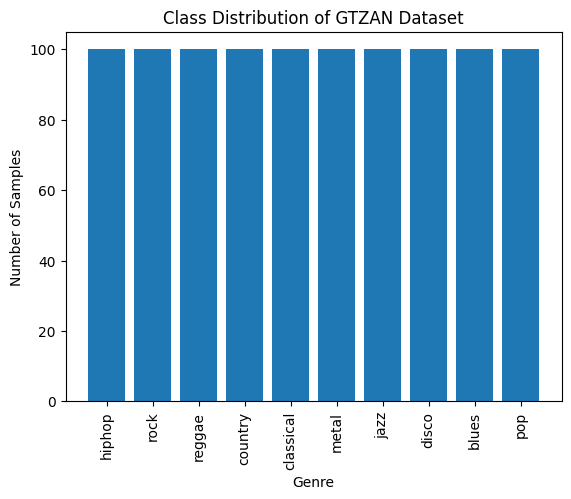

In [ ]:
# Calculate the number of samples per genre
genre_counts = {genre: len(audio_files) for genre, audio_files in song_dct.items()}

# Create a bar chart to visualize the class distribution
plt.bar(genre_counts.keys(), genre_counts.values())
plt.xlabel('Genre')
plt.ylabel('Number of Samples')
plt.title('Class Distribution of GTZAN Dataset')
plt.xticks(rotation=90)
plt.show()

## 2. Data Preprocessing

### 2.1 Convert to Spectrograms

In [ ]:
# Prepare empty dictionaries to store the Mel spectrograms and rejected files
mel_spectrograms = {}
rejected_files = {}

for label, files in song_dct.items():
    mel_spectrograms[label] = []  # Initialize empty list for this label
    for file in files:
        # Construct full file path
        file_path = f'/content/drive/My Drive/DS 5500/Data/genres_original/{label}/{file}'

        try:
            # Load audio file
            y, sr = librosa.load(file_path)
            y, _ = librosa.effects.trim(y)

            # Compute Mel spectrogram
            mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

            # Convert to log scale
            log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

            # Append log Mel spectrogram to list for this label
            mel_spectrograms[label].append(log_mel_spectrogram)
        except Exception as e:
            print(f"Could not process file {file_path}: {e}")
            if label in rejected_files:
                rejected_files[label].append(file_path)
            else:
                rejected_files[label] = [file_path]

# Determine the maximum number of time steps (keeps all images the same size)
max_time_steps = 0
for label, spectrograms in mel_spectrograms.items():
    for spectrogram in spectrograms:
        if spectrogram.shape[1] > max_time_steps:
            max_time_steps = spectrogram.shape[1]

# Pad the spectrograms with zeros to the max number of time steps
for label, spectrograms in mel_spectrograms.items():
    for i in range(len(spectrograms)):
        pad_size = max_time_steps - spectrograms[i].shape[1]
        if pad_size > 0:
            mel_spectrograms[label][i] = np.pad(
                mel_spectrograms[label][i],
                pad_width=((0, 0), (0, pad_size)),
                mode='constant'
            )

# Convert the spectrograms to numpy arrays
for label, spectrograms in mel_spectrograms.items():
    mel_spectrograms[label] = np.array(spectrograms)

print(f"Processed files. {len(rejected_files)} files were rejected.")

<ipython-input-7-8f45ef1669a2>:13: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Could not process file /content/drive/My Drive/DS 5500/Data/genres_original/jazz/jazz.00054.wav: 
Processed files. 1 files were rejected.


In [ ]:
rejected_files

{'jazz': ['/content/drive/My Drive/DS 5500/Data/genres_original/jazz/jazz.00054.wav']}

### 2.2 Convert to MFCCs

Mel Frequency Cepstral Coefficients - MFCCs are derived from the short-term power spectrum of an audio signal and are used to represent the spectral characteristics of the signal in a compact form.

In [ ]:
mfcc_dict = {}
rejected_files = {}
for genre in song_dct.keys():
  audio_files = song_dct[genre]
  mfcc_dict[genre] = []
  for audio in audio_files:
    audio_file_path = f'{base_path}/Data/genres_original/{genre}/{audio}'

    try:
      # Load audio file
      y, sr = librosa.load(audio_file_path)

      # Extract MFCC features
      mfcc = librosa.feature.mfcc(y=y, sr=sr)
      # print(type(mfcc), mfcc.shape)
      mfcc_dict[genre].append(mfcc)

    except Exception as e:
        print(f"Could not process file {audio_file_path}: {e}")
        if label in rejected_files:
            rejected_files[label].append(audio_file_path)
        else:
            rejected_files[label] = [audio_file_path]

<ipython-input-9-bd203d68c2ef>:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_file_path)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Could not process file /content/drive/My Drive/DS 5500/Data/genres_original/jazz/jazz.00054.wav: 


### 2.3 Experimenting with one sample audio file to understand features

In [ ]:
sample_audio_file = song_dct['jazz'][0]
sample_audio_file_path = f'{base_path}/Data/genres_original/jazz/{sample_audio_file}'
sample_audio_file_path

'/content/drive/My Drive/DS 5500/Data/genres_original/jazz/jazz.00000.wav'

In [ ]:
audio, sr = librosa.load(sample_audio_file_path)
# array representing the amplitude of the audio signal at each time sample.
print(audio)
# dimensions of the waveform, represented as (number of samples,).
# Number of samples represents the length of the audio waveform.
print("Shape: ", audio.shape)
# Sampling rate - number of samples taken per second to represent the audio signal.
print("Sample Rate in KHz:", sr)
# Total number of samples in  audio waveform (661794) / sampling rate (22050)
print('Length of audio:', 661794/22050)

[-0.00924683 -0.01177979 -0.01370239 ...  0.0071106   0.00561523
  0.00561523]
Shape:  (661794,)
Sample Rate in KHz: 22050
Length of audio: 30.013333333333332


In [ ]:
IPython.display.Audio(audio, rate=sr)

In [ ]:
# Trim leading and trailing silence from an audio signal
audio_file_trim, trim_sr = librosa.effects.trim(audio)
print('Trimmed Audio File:', audio_file_trim)
print('Shapes, not trimmed and trimmed:', audio.shape, audio_file_trim.shape)

Trimmed Audio File: [-0.00924683 -0.01177979 -0.01370239 ...  0.0071106   0.00561523
  0.00561523]
Shapes, not trimmed and trimmed: (661794,) (661794,)


In [ ]:
IPython.display.Audio(audio_file_trim, rate=sr)

### Visualize sounds waves

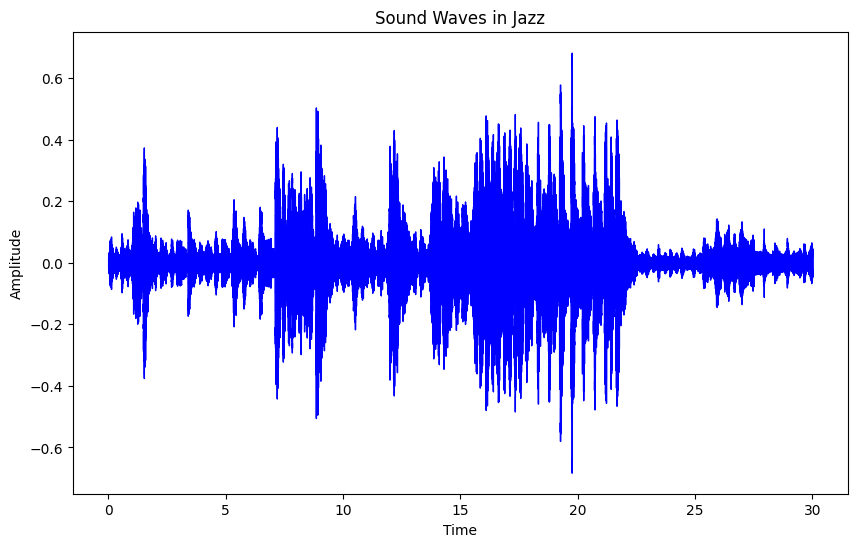

In [ ]:
# Plot the waveform
plt.figure(figsize=(10, 6))
librosa.display.waveshow(audio_file_trim, sr=sr, color="blue")
plt.title("Sound Waves in Jazz")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

### Zero Crossing Rate

Rate at which the signal changes from positive to negative or back. Zero crossings occur when the audio waveform changes sign from positive to negative or vice versa. The zero_crossings function returns a boolean array where each element indicates whether a zero crossing occurs at that particular sample index.

Sum of the boolean array zero_crossings. Since True is considered as 1 and False as 0, summing the array gives us the total count of zero crossings in the audio signal.

In [ ]:
# Total zero_crossings in our 1 song
zero_crossings = librosa.zero_crossings(audio_file_trim, pad=False)
print(sum(zero_crossings))

51961


### Harmonics and Perceptual¶

Using harmonic-percussive source separation (HPSS) to separate an audio signal into harmonic and percussive components

Harmonics are characteristics that humans can't distinguish, pitched sounds like melodies or instruments

Perceptrual understanding shock wave represents the sound rhythm and emotion, non-pitched sounds like drums or percussive elements

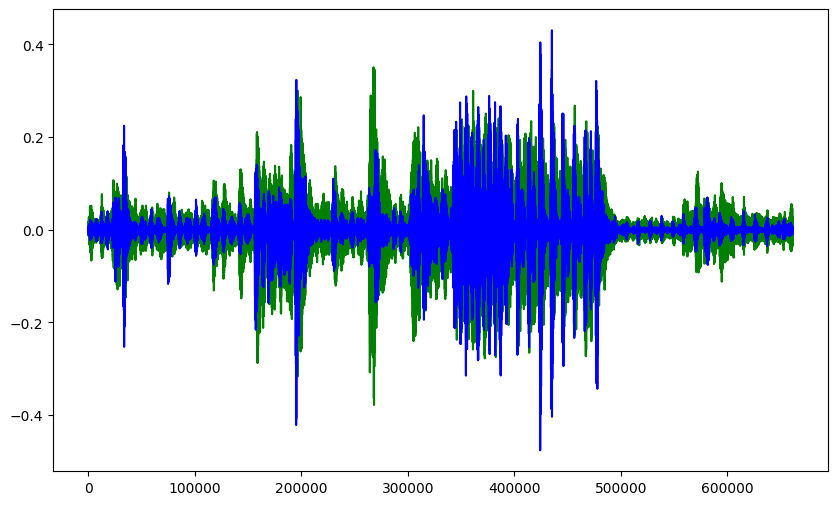

In [ ]:
y_harm, y_perc = librosa.effects.hpss(audio_file_trim)

plt.figure(figsize = (10, 6))
plt.plot(y_harm, color = 'green');
plt.plot(y_perc, color = 'blue');

### Tempo BMP (beats per minute)

Beat tracking algorithm is used to estimate the tempo or the beats per minute (BPM) in a piece of music. By estimating the tempo of an audio signal, we can determine its underlying rhythm and tempo characteristics.


In [ ]:
tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
print(f"Tempo: {tempo:.2f} BPM")

Tempo: 107.67 BPM


To scale the values of the sound data within a specific range or distribution.

In [ ]:
# Function that normalizes the Sound Data
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

### Spectral Centroid

This is a measure used in digital signal processing to characterize a spectrum. It indicates where the "center of mass" of the spectrum is located. In terms of audio classification, the spectral centroid is often associated with the perceived "brightness" of a sound. A higher spectral centroid generally corresponds to a "brighter" or "sharper" sound, while a lower centroid corresponds to a "darker" or "muddier" sound.

Centroids: [1840.0864235  1918.86872672 1714.390796   ...  831.37619257  794.3915672
  811.36986648]
Spectral Centroids Shape: (1293,)
Frames: range(0, 1293)
t: [0.00000000e+00 2.32199546e-02 4.64399093e-02 ... 2.99537415e+01
 2.99769615e+01 3.00001814e+01]


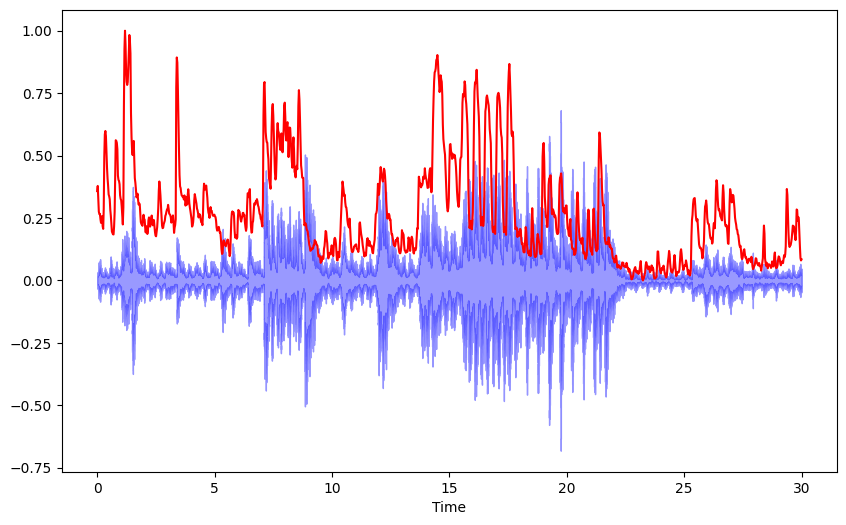

In [ ]:
# Calculate the Spectral Centroids
spectral_centroids = librosa.feature.spectral_centroid(y=audio_file_trim, sr=sr)[0]

print('Centroids:', spectral_centroids)
print('Spectral Centroids Shape:', spectral_centroids.shape)

frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
print('Frames:', frames)
print('t:', t)

plt.figure(figsize = (10, 6))
librosa.display.waveshow(audio_file_trim, sr=sr, alpha=0.4, color = 'blue');
plt.plot(t, normalize(spectral_centroids), color='red');

### Spectral Rolloff

This is a measure of the shape of the signal's power spectral density. It's the frequency below which a specified percentage (commonly 85-95%) of the total spectral energy lies. Spectral rolloff can be useful for distinguishing between musical instruments, for example, or other types of audio content with distinct spectral characteristics.

Spectral Rolloff (1293,)


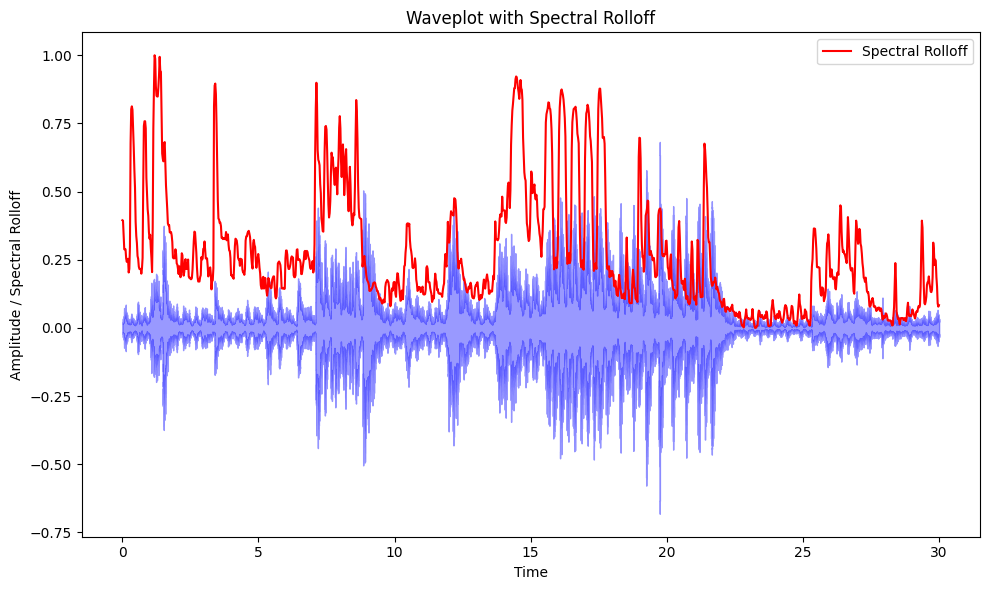

In [ ]:
# Spectral RollOff Vector
spectral_rolloff = librosa.feature.spectral_rolloff(y=audio_file_trim, sr=sr)[0]
print("Spectral Rolloff", spectral_rolloff.shape)

plt.figure(figsize=(10, 6))
librosa.display.waveshow(audio_file_trim, sr=sr, alpha=0.4, color='blue')
plt.plot(t, normalize(spectral_rolloff), color='red', label='Spectral Rolloff')
plt.title('Waveplot with Spectral Rolloff')
plt.xlabel('Time')
plt.ylabel('Amplitude / Spectral Rolloff')
plt.legend()
plt.tight_layout()
plt.show()

### Mel-Frequency Cepstral Coefficients:
 These are coefficients that collectively make up an MFC. They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum"). The Mel scale is a perceptual scale of pitches judged by listeners to be equal in distance from one another, which closely aligns with human auditory system’s response. Hence, it is widely used in speech and music processing as it can mimic the human ears' response better than linearly-spaced frequency bands. MFCCs are commonly used features for speech and music classification tasks.

 Differences comapred to Mel Spectrograms:

  1. less dimensionality due to being a vector of coeffcients
  2. Better suited for speech recognition than music classification

MFCC shape (20, 1293)


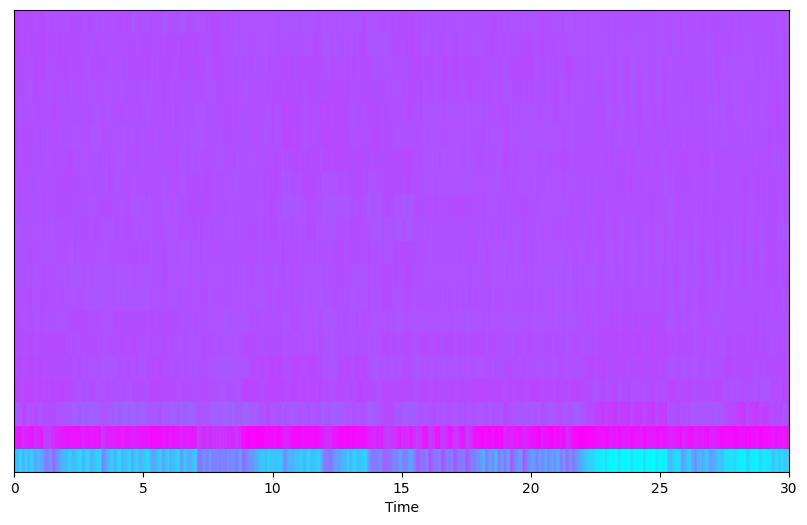

In [ ]:
mfcc = librosa.feature.mfcc(y=audio_file_trim, sr=sr)
print("MFCC shape", mfcc.shape)
plt.figure(figsize = (10, 6))
librosa.display.specshow(mfcc, sr=sr, x_axis='time', cmap = 'cool');


# mfcc = librosa.feature.mfcc(y=y, sr=sr)
# df = pd.DataFrame(mfcc)

# # Visualize the distribution of MFCC coefficients
# plt.figure(figsize=(10, 6))
# df.boxplot()
# plt.title('Distribution of MFCC Coefficients')
# plt.xlabel('MFCC Coefficients')
# plt.ylabel('Amplitude')
# plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:259: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Mean: -6.933131e-09 

Var: 1.0


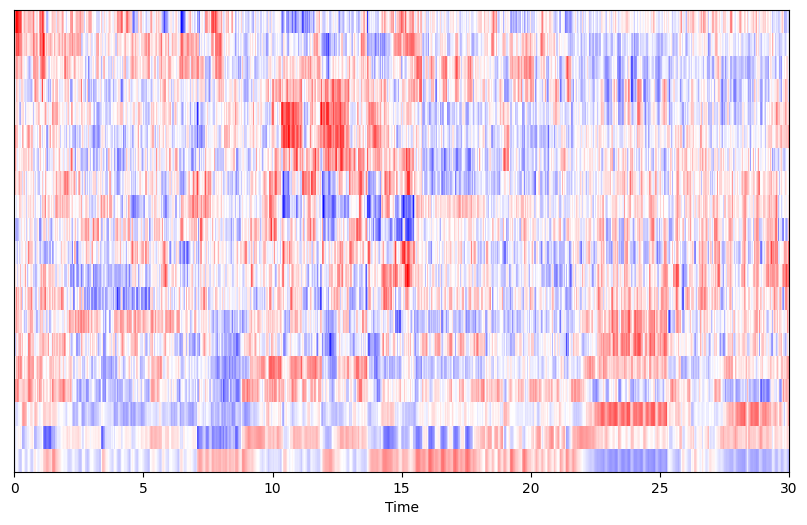

In [ ]:
mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
print('Mean:', mfcc.mean(), '\n')
print('Var:', mfcc.var())

plt.figure(figsize = (10, 6))
librosa.display.specshow(mfcc, sr=sr, x_axis='time', cmap = 'bwr');

### Chroma Frequencies
 Chroma features are an interesting and powerful representation for music audio in which the entire spectrum is projected onto 12 bins representing the 12 distinct semitones (or chroma) of the musical octave. This means that all the energy at one particular chroma (say all 'C's or all 'D's) will be summed, regardless of the octave it is in. Since, in many types of music, melody and harmony are often defined by pitch classes or chroma (A, A#, B, C, etc.) irrespective of the actual frequency or octave, this type of feature can be very informative for music classification tasks.



Chromogram shape: (12, 1293)


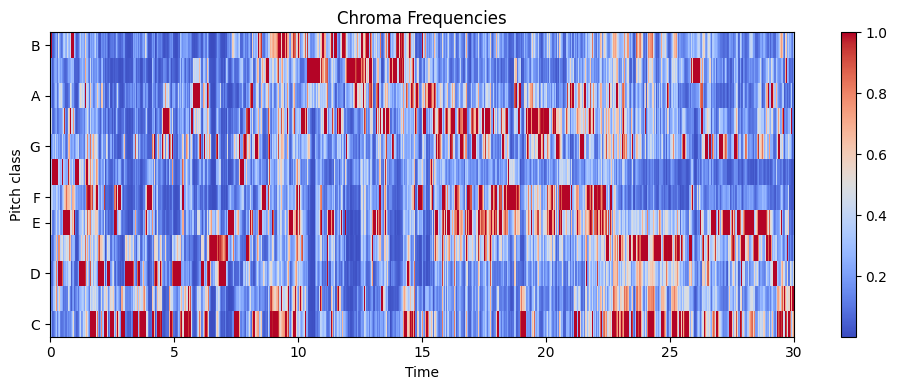

In [ ]:
# Compute chroma feature
chroma = librosa.feature.chroma_stft(y=audio_file_trim, sr=sr)
print('Chromogram shape:', chroma.shape)

# Plot the chroma feature
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', cmap='coolwarm')
plt.colorbar()
plt.title('Chroma Frequencies')
plt.tight_layout()
plt.show()

<ipython-input-26-07aa623a9f01>:12: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_file_path)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Could not process file /content/drive/My Drive/DS 5500/Data/genres_original/jazz/jazz.00054.wav: 


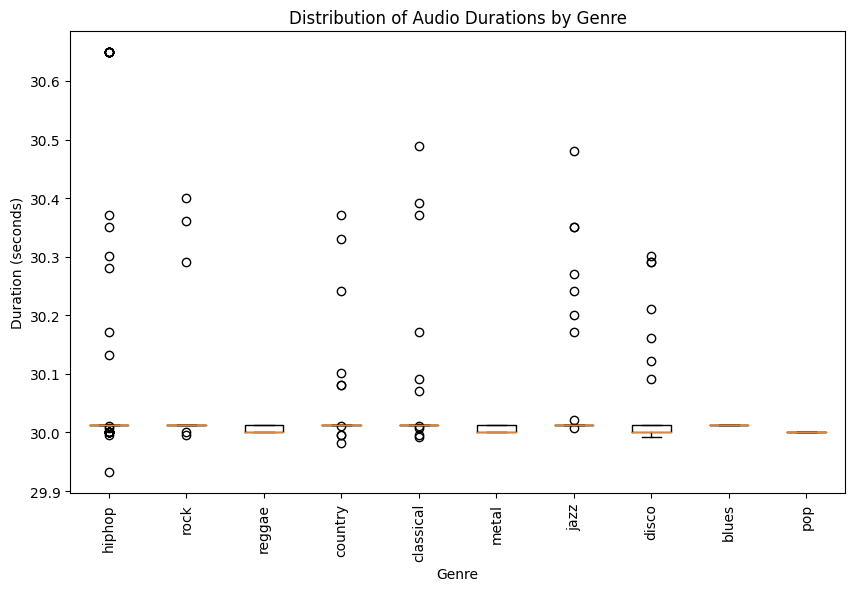

Genre: hiphop
Mean: 30.09 seconds
Median: 30.01 seconds
Minimum: 29.93 seconds
Maximum: 30.65 seconds

Genre: rock
Mean: 30.02 seconds
Median: 30.01 seconds
Minimum: 30.00 seconds
Maximum: 30.40 seconds

Genre: reggae
Mean: 30.01 seconds
Median: 30.00 seconds
Minimum: 30.00 seconds
Maximum: 30.01 seconds

Genre: country
Mean: 30.02 seconds
Median: 30.01 seconds
Minimum: 29.98 seconds
Maximum: 30.37 seconds

Genre: classical
Mean: 30.03 seconds
Median: 30.01 seconds
Minimum: 29.99 seconds
Maximum: 30.49 seconds

Genre: metal
Mean: 30.00 seconds
Median: 30.00 seconds
Minimum: 30.00 seconds
Maximum: 30.01 seconds

Genre: jazz
Mean: 30.03 seconds
Median: 30.01 seconds
Minimum: 30.01 seconds
Maximum: 30.48 seconds

Genre: disco
Mean: 30.02 seconds
Median: 30.00 seconds
Minimum: 29.99 seconds
Maximum: 30.30 seconds

Genre: blues
Mean: 30.01 seconds
Median: 30.01 seconds
Minimum: 30.01 seconds
Maximum: 30.01 seconds

Genre: pop
Mean: 30.00 seconds
Median: 30.00 seconds
Minimum: 30.00 seconds


In [ ]:
genre_durations = {}

# Iterate over each genre/label
for genre, audio_files in song_dct.items():
    durations = []

    # Iterate over each audio file in the genre
    for audio in audio_files:
        audio_file_path = os.path.join(base_path, 'Data/genres_original', genre, audio)
        try:
            # Load audio file and get its duration
            y, sr = librosa.load(audio_file_path)
            audio_duration = librosa.get_duration(y=y, sr=sr)
            durations.append(audio_duration)
        except Exception as e:
            print(f"Could not process file {audio_file_path}: {e}")
            continue

    # Store durations for the genre
    genre_durations[genre] = durations

# Calculate summary statistics for each genre
genre_statistics = {}
for genre, durations in genre_durations.items():
    duration_mean = np.mean(durations)
    duration_median = np.median(durations)
    duration_min = np.min(durations)
    duration_max = np.max(durations)
    genre_statistics[genre] = {
        'Mean': duration_mean,
        'Median': duration_median,
        'Minimum': duration_min,
        'Maximum': duration_max
    }

# Visualize the distribution of audio durations using box plots
plt.figure(figsize=(10, 6))
plt.boxplot(genre_durations.values())
plt.xticks(range(1, len(genre_durations) + 1), genre_durations.keys(), rotation=90)
plt.xlabel('Genre')
plt.ylabel('Duration (seconds)')
plt.title('Distribution of Audio Durations by Genre')
plt.show()

# Print summary statistics for each genre
for genre, statistics in genre_statistics.items():
    print(f"Genre: {genre}")
    print(f"Mean: {statistics['Mean']:.2f} seconds")
    print(f"Median: {statistics['Median']:.2f} seconds")
    print(f"Minimum: {statistics['Minimum']:.2f} seconds")
    print(f"Maximum: {statistics['Maximum']:.2f} seconds")
    print()

## Pre-processing CSV file having features

In [ ]:
# Reading the csv file
features_df = pd.read_csv(f"{base_path}/Data/features_30_sec.csv")
features_df.head()

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.wav  661794          0.350088         0.088757  0.130228   
1  blues.00001.wav  661794          0.340914         0.094980  0.095948   
2  blues.00002.wav  661794          0.363637         0.085275  0.175570   
3  blues.00003.wav  661794          0.404785         0.093999  0.141093   
4  blues.00004.wav  661794          0.308526         0.087841  0.091529   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.002827             1784.165850          129774.064525   
1  0.002373             1530.176679          375850.073649   
2  0.002746             1552.811865          156467.643368   
3  0.006346             1070.106615          184355.942417   
4  0.002303             1835.004266          343399.939274   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              2002.449060            85882.761315  ...   52.420910   
1              2039.036516           213843.755497  ...   55.356403   
2              1747.702312            76254.192257  ...   40.598766   
3              1596.412872           166441.494769  ...   44.427753   
4              1748.172116            88445.209036  ...   86.099236   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -1.690215   36.524071    -0.408979   41.597103    -2.303523   55.062923   
1    -0.731125   60.314529     0.295073   48.120598    -0.283518   51.106190   
2    -7.729093   47.639427    -1.816407   52.382141    -3.439720   46.639660   
3    -3.319597   50.206673     0.636965   37.319130    -0.619121   37.259739   
4    -5.454034   75.269707    -0.916874   53.613918    -4.404827   62.910812   

   mfcc20_mean  mfcc20_var  label  
0     1.221291   46.936035  blues  
1     0.531217   45.786282  blues  
2    -2.231258   30.573025  blues  
3    -3.407448   31.949339  blues  
4   -11.703234   55.195160  blues  

[5 rows x 60 columns]

In [ ]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 1000 non-null   object 
 1   length                   1000 non-null   int64  
 2   chroma_stft_mean         1000 non-null   float64
 3   chroma_stft_var          1000 non-null   float64
 4   rms_mean                 1000 non-null   float64
 5   rms_var                  1000 non-null   float64
 6   spectral_centroid_mean   1000 non-null   float64
 7   spectral_centroid_var    1000 non-null   float64
 8   spectral_bandwidth_mean  1000 non-null   float64
 9   spectral_bandwidth_var   1000 non-null   float64
 10  rolloff_mean             1000 non-null   float64
 11  rolloff_var              1000 non-null   float64
 12  zero_crossing_rate_mean  1000 non-null   float64
 13  zero_crossing_rate_var   1000 non-null   float64
 14  harmony_mean             

In [ ]:
features_df.shape

(1000, 60)